# Recommnedation Systems Poplarity and Collabarative Filtering

1.Read and explore the given dataset. ( Rename column/add headers, plot histograms,
find data characteristics)
2. Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the
users only who has given 50 or more number of ratings )
3. Build Popularity Recommender model.
4. Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio)
5. Build Collaborative Filtering model.
6. Evaluate the above model. ( Once the model is trained on the training data, it can be
used to compute the error (like RMSE) on predictions made on the test data.) You can
also use a different method to evaluate the models.
7. Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to
each user based on his/her habits, we will recommend 5 new products.
8. Summarise your insights.
## Summarising of Insights As the data set is vast we have to subset for the ratings for than 50 ,overall the accuracy in the K splits is around 99 in the 4th split which shows that the RMSE whcih we got is the best .
# we have indentifiwed users which similar taught process where we understand the similar purchase patterns of the user ,in case any new items lauched we have to do the item item we have suggested the new product to the user or with the help of SVD also we can acheive our Target,


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('ratings_electronics.csv', names=['userId', 'productId', 'ratings','timestamp'])
df.head(5)

,userId,productId,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [3]:
df.shape

(7824482, 4)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
userId       object
productId    object
ratings      float64
timestamp    int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [5]:
df.describe()

,ratings,timestamp
count,7.824482e+06,7.824482e+06
mean,4.012337e+00,1.338178e+09
std,1.380910e+00,6.900426e+07
min,1.000000e+00,9.127296e+08
25%,3.000000e+00,1.315354e+09
50%,5.000000e+00,1.361059e+09
75%,5.000000e+00,1.386115e+09
max,5.000000e+00,1.406074e+09


In [6]:
##missing_values 
df.isnull().sum()

userId       0
productId    0
ratings      0
timestamp    0
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FA0084EA58>]],
      dtype=object)

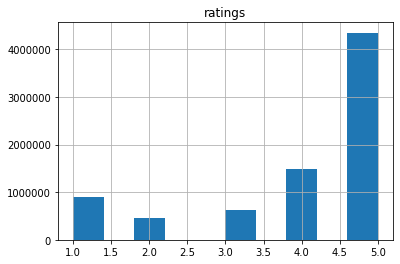

In [7]:
df.hist(column='ratings')

In [8]:
countdf = df.groupby('userId').count()
result = df.loc[df['userId'].isin(countdf[countdf['ratings'] > 50].index)]

In [9]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122171 entries, 118 to 7824444
Data columns (total 4 columns):
userId       122171 non-null object
productId    122171 non-null object
ratings      122171 non-null float64
timestamp    122171 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.7+ MB


In [10]:
result.shape

(122171, 4)

In [11]:
df.groupby('productId')['ratings'].mean().sort_values(ascending = False).head(10)

productId
BT008V9J9U    5.0
B0058PPK8Y    5.0
B0058OQ9Q2    5.0
B0058OKSMS    5.0
B0058OHGX2    5.0
B0058O9OR8    5.0
B0058O6O8K    5.0
B0058O6J3A    5.0
B0058O6EXA    5.0
B0058O0CMO    5.0
Name: ratings, dtype: float64

In [12]:
rating_mean_count = pd.DataFrame(df.groupby('productId')['ratings'].mean().sort_values())

In [13]:
rating_mean_count['rating_counts'] = pd.DataFrame(df.groupby('productId')['ratings'].count())


In [14]:
rating_mean_count.head(10)

,ratings,rating_counts
productId,,
B008ANKWMA,1.0,1
B0021HEJKC,1.0,1
B00FAVJXUW,1.0,1
B00J5ARFNG,1.0,1
B008LT3D6A,1.0,1
B008LT2WZI,1.0,2
B0021MI8EA,1.0,1
B0021NN74U,1.0,1
B0000AC8A2,1.0,1


In [15]:
min_votes = 10
mean_rating_dataset = np.mean(rating_mean_count.ratings.values)
def weighted_rating(rating_mean_count, min_votes, mean_rating_dataset):
    weighted_rating = list()
    V = rating_mean_count.rating_counts.values
    R = rating_mean_count.ratings.values
    for v, r in zip(V, R):
        if v < 10:
            weighted_rating.append(0)
        else:
            weighted_rating.append((v/(v+min_votes))*r + (min_votes/(v+min_votes))*mean_rating_dataset)
    return(weighted_rating)

rating_mean_count['weighted_rating'] = weighted_rating(rating_mean_count, min_votes, mean_rating_dataset)
rating_mean_count.weighted_rating.sort_values(ascending = False).head(10)

productId
B00CG70K78    4.906466
B00GMRCAC6    4.897954
B008VGCT9K    4.895404
B000053HC5    4.885778
B0043WJRRS    4.877437
B0033PRWSW    4.876315
B007SZ0E1K    4.873414
B0041OYTJE    4.858754
B008I6RVZU    4.857496
B002NEGTSI    4.857272
Name: weighted_rating, dtype: float64

## Collaborative Filtering

In [16]:
from surprise import KNNWithMeans
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import KFold
from surprise.model_selection import GridSearchCV

In [17]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(result[['userId', 'productId', 'ratings']], reader)
trainset, testset = train_test_split(data, test_size=.20)

In [18]:
algo = KNNWithMeans(k=20, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [19]:
test_pred = algo.test(testset)

In [20]:
# get RMSE
print("User-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

User-based Model : Test Set
RMSE: 1.0553


1.0552883485835507

In [21]:
kf = KFold(n_splits=5)

algo = SVD()

for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    accuracy.rmse(predictions, verbose=True)

RMSE: 0.9861
RMSE: 0.9798
RMSE: 0.9835
RMSE: 0.9752
RMSE: 0.9763


In [22]:
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)


print(gs.best_score['rmse'])


print(gs.best_params['rmse'])

0.9861488057191615
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


In [23]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
df.head()

,uid,iid,rui,est,details,Iu,Ui,err
0,AI0BCEWRE04G0,B00134VVKU,3.0,4.542609,{'was_impossible': False},56,2,1.542609
1,A27Y4OEC9MD9PA,B000JNQSIQ,5.0,4.748948,{'was_impossible': False},46,7,0.251052
2,A11ULAZ4B5ZXC8,B0002V85OU,5.0,4.972880,{'was_impossible': False},54,2,0.027120
3,ALRCAGJOJ9583,B0015AE4CE,3.0,4.310884,{'was_impossible': False},65,5,1.310884
4,AGR1V15L6FLMA,B004C19GYE,5.0,4.314514,{'was_impossible': False},59,1,0.685486


In [24]:
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [25]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
847,A24HWYHR28JJ7A,B00017LSPI,5.0,5.0,{'was_impossible': False},98,40,0.0
22664,A2NOW4U7W3F7RI,B00113XADE,5.0,5.0,{'was_impossible': False},210,3,0.0
19218,A25HBO5V8S8SEA,B000069JWS,5.0,5.0,{'was_impossible': False},135,1,0.0
13984,A1TQBAHI3M4ZBQ,B00114LG7U,5.0,5.0,{'was_impossible': False},55,4,0.0
10972,A54SG05AV6S4H,B001VEAI74,5.0,5.0,{'was_impossible': False},66,4,0.0
14034,AYB4ELCS5AM8P,B00L21HC7A,5.0,5.0,{'was_impossible': False},133,11,0.0
17184,A18U49406IPPIJ,B00FR8Z75I,5.0,5.0,{'was_impossible': False},88,4,0.0
4656,AELK0E5DK7LIZ,B00COF7DGS,5.0,5.0,{'was_impossible': False},43,17,0.0
17906,A1143YEAZYMYHJ,B00894YP00,5.0,5.0,{'was_impossible': False},73,20,0.0
19191,A2OOXVZ6B1VZ9A,B002WE6D44,5.0,5.0,{'was_impossible': False},43,79,0.0


# Method 2

In [26]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(result[['userId', 'productId', 'ratings']], reader)
trainset, testset = train_test_split(data, test_size=.20)

In [27]:
from surprise import SVD

In [28]:
algo = SVD()
algo.fit(trainset)

In [29]:
predictions = algo.test(testset)

In [30]:
print("SVD Model : Test Set")
accuracy.rmse(predictions, verbose=True)

SVD Model : Test Set
RMSE: 0.9773


0.9773447085318885

In [31]:
def get_Iu(uid):
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: 
        return 0
    
def get_Ui(iid):
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
df.head()

,uid,iid,rui,est,details,Iu,Ui,err
0,A3E9O1VNJ3U324,B0014LC9S0,5.0,4.282153,{'was_impossible': False},46,1,0.717847
1,A17Z0LVY96TO53,B0007WK8KS,5.0,4.691988,{'was_impossible': False},46,2,0.308012
2,A3S3R88HA0HZG3,B006TT91TW,5.0,5.000000,{'was_impossible': False},107,22,0.000000
3,AG8YP2XTC5X1I,B00004Z5KG,5.0,4.470481,{'was_impossible': False},45,0,0.529519
4,A1C82BC5GNABOA,B004LEAYXY,3.0,4.356621,{'was_impossible': False},48,8,1.356621


In [32]:
best_predictions = df.sort_values(by='err')[:10]

In [33]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
9431,A2HDTOF8222KN3,B0002YE686,5.0,5.0,{'was_impossible': False},46,3,0.0
19936,A3J3ZHGDUDPCFL,B00BOHNYU6,5.0,5.0,{'was_impossible': False},40,49,0.0
23983,A15TABNGK6L4N3,B0083EZE4M,5.0,5.0,{'was_impossible': False},43,1,0.0
19141,A3DOPYDOS49I3T,B00A0JUNWQ,5.0,5.0,{'was_impossible': False},86,14,0.0
12864,A2LTYEYGKBYXRR,B009SYZ8OC,5.0,5.0,{'was_impossible': False},69,81,0.0
11357,A3MQ15651KGVLJ,B004CLYEFK,5.0,5.0,{'was_impossible': False},81,70,0.0
2987,A1EVV74UQYVKRY,B00B3YQGHS,5.0,5.0,{'was_impossible': False},164,9,0.0
20636,A2QDOJFFLFGF18,B0079UAT0A,5.0,5.0,{'was_impossible': False},67,75,0.0
9056,A1Z3598J0371ND,B0019EHU8G,5.0,5.0,{'was_impossible': False},46,67,0.0
3875,A3LDFTSXU3UPBO,B006UMM1PO,5.0,5.0,{'was_impossible': False},46,8,0.0
